Dataset Shape: (308854, 19)


c:\Users\visdas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.8408
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     56777
           1       0.20      0.81      0.33      4994

    accuracy                           0.73     61771
   macro avg       0.59      0.77      0.58     61771
weighted avg       0.92      0.73      0.79     61771

✅ Model saved as cardio_model.joblib


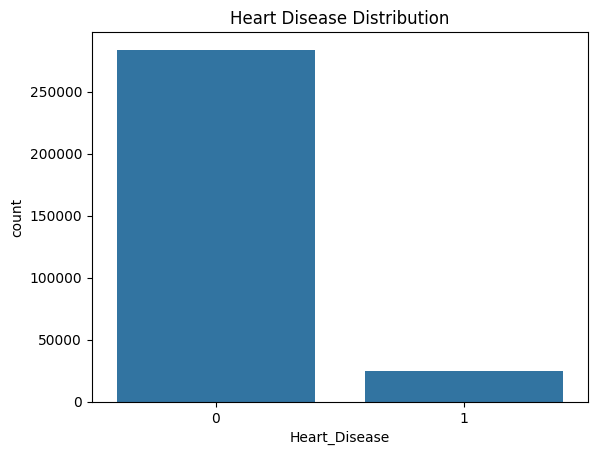

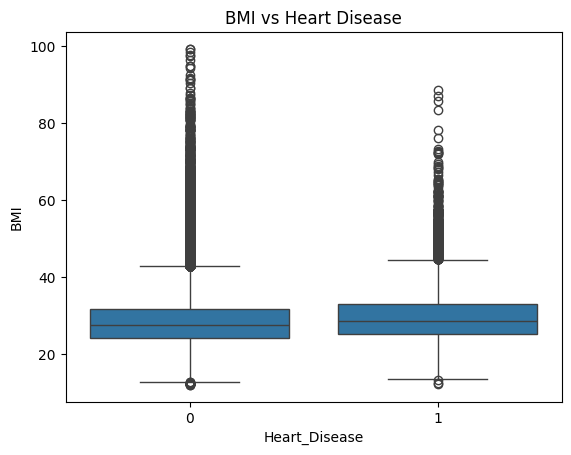

In [3]:
# ==========================================
# Cardiovascular Disease Prediction Model
# ==========================================

import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv(r"D:\cardiovascular_disease_risk_prediction\data\CVD_cleaned.csv")
print("Dataset Shape:", df.shape)

# -------------------------------
# Preprocess Target & Columns
# -------------------------------
def _map_binary(series):
    mapping = {'yes': 1, 'no': 0, 'Yes': 1, 'No': 0, 'Y': 1, 'N': 0, True: 1, False: 0}
    return series.map(lambda x: mapping.get(x, x))

df['Heart_Disease'] = _map_binary(df['Heart_Disease'])
df = df.dropna()

# Column order matches Streamlit app
columns_order = [
    'General_Health','Checkup','Exercise','Skin_Cancer','Other_Cancer','Depression',
    'Diabetes','Arthritis','Sex','Age_Category','Smoking_History',
    'Height_(cm)','Weight_(kg)','BMI','Alcohol_Consumption','Fruit_Consumption',
    'Green_Vegetables_Consumption','FriedPotato_Consumption','Heart_Disease'
]
df = df[columns_order]

# -------------------------------
# Features & Target
# -------------------------------
X = df.drop(columns=['Heart_Disease'])
y = df['Heart_Disease']

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# -------------------------------
# Preprocessing Pipelines
# -------------------------------
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# -------------------------------
# Handle Class Imbalance using scale_pos_weight
# -------------------------------
pos = sum(y==1)
neg = sum(y==0)
scale_pos_weight = neg / pos

# -------------------------------
# Model Pipeline
# -------------------------------
model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    ))
])

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")
print(classification_report(y_test, y_pred))

# -------------------------------
# Save Model
# -------------------------------
joblib.dump(model, "cardio_model.joblib")
print("✅ Model saved as cardio_model.joblib")

# -------------------------------
# Visualization
# -------------------------------
sns.countplot(x='Heart_Disease', data=df)
plt.title("Heart Disease Distribution")
plt.show()

sns.boxplot(x='Heart_Disease', y='BMI', data=df)
plt.title("BMI vs Heart Disease")
plt.show()
